# Statistics
## Load packages

In [78]:
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import seaborn as sns

import warnings

from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
warnings.filterwarnings('ignore')

## Import data

In [12]:
# load data
df = pd.read_csv('Data_34.csv',encoding='utf-8')
df30 = df.head(30)
df30.head()

,Title,Status,Total Score,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度,穩定程度,評估,評估（考量台灣）
0,Avian Influenza A H10N3 in China,Low,23,3,3,1,1,2,1,3,3,1,3,2,Medium,Medium
1,Measles in Canada,Medium,20,2,3,3,3,3,1,1,1,1,1,1,High,Medium
2,Rabies in Timor Leste,Watchlist,27,3,3,3,3,1,3,3,1,3,2,2,High,Medium
3,Measles in United States,Medium,22,2,3,3,3,3,1,1,1,1,2,2,Medium,Medium
4,Avian Influenza in Vietnam,Low,26,3,3,2,2,2,3,3,3,2,2,1,Medium,Medium


In [13]:
df30m = df30.iloc[:,3:13]
df30m.head()

,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度
0,3,3,1,1,2,1,3,3,1,3
1,2,3,3,3,3,1,1,1,1,1
2,3,3,3,3,1,3,3,1,3,2
3,2,3,3,3,3,1,1,1,1,2
4,3,3,2,2,2,3,3,3,2,2


## Correlation and Covariance

In [18]:
# 進行matplotlib繪圖時顯示繁體中文
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mp.rc('font', family='Taipei Sans TC Beta')

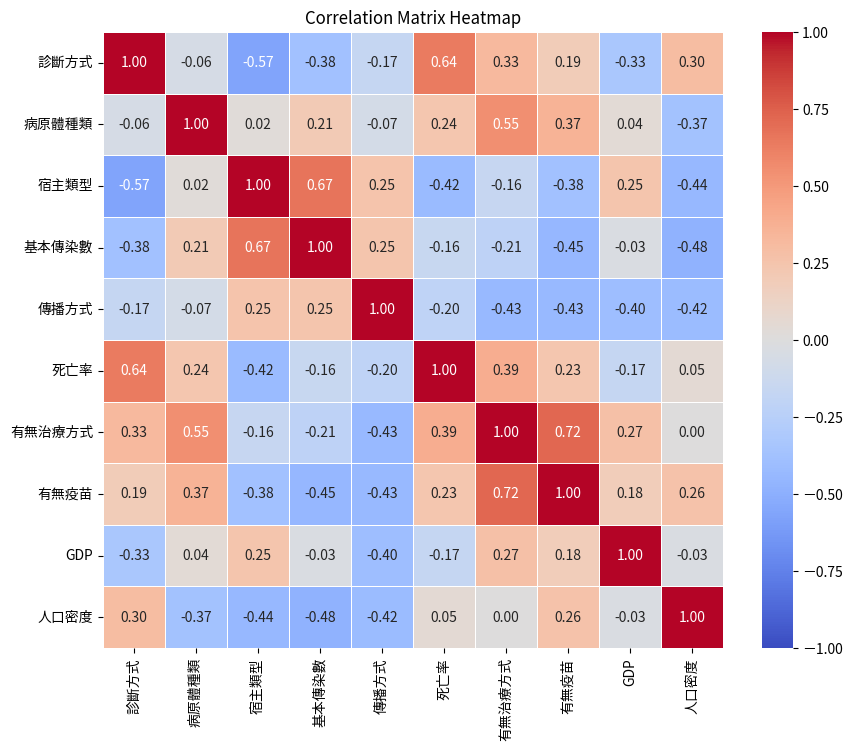

In [19]:
# correlation
df30m_cor = df30m.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df30m_cor, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [27]:
# VIF
vif = pd.DataFrame()
vif["feature"] = df30m.columns

vif["VIF"] = [variance_inflation_factor(df30m.values, i) for i in range(len(df30m.columns))]
vif

,feature,VIF
0,診斷方式,53.770155
1,病原體種類,81.073667
2,宿主類型,51.285228
3,基本傳染數,43.200557
4,傳播方式,12.901103
5,死亡率,9.715179
6,有無治療方式,23.528449
7,有無疫苗,18.940298
8,GDP,8.971340
9,人口密度,27.396705


In [38]:
# PCA
pca = PCA(n_components=4)
newX = pca.fit_transform(df30m)
invX = pca.inverse_transform(newX)
pca.explained_variance_ratio_

array([0.42518691, 0.18808638, 0.13149485, 0.10235782])

## Statistics

In [40]:
df30['Status'] = df30['Status'].map({'Watchlist': 1, 'Low': 2, 'Medium': 3})
df30.head()

,Title,Status,Total Score,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度,穩定程度,評估,評估（考量台灣）
0,Avian Influenza A H10N3 in China,2,23,3,3,1,1,2,1,3,3,1,3,2,Medium,Medium
1,Measles in Canada,3,20,2,3,3,3,3,1,1,1,1,1,1,High,Medium
2,Rabies in Timor Leste,1,27,3,3,3,3,1,3,3,1,3,2,2,High,Medium
3,Measles in United States,3,22,2,3,3,3,3,1,1,1,1,2,2,Medium,Medium
4,Avian Influenza in Vietnam,2,26,3,3,2,2,2,3,3,3,2,2,1,Medium,Medium


In [41]:
# regression
df30name = [df30.columns[1]] + list(df30.columns[3:13])
df30m2 = df30[df30name]
df30m2.head()

,Status,診斷方式,病原體種類,宿主類型,基本傳染數,傳播方式,死亡率,有無治療方式,有無疫苗,GDP,人口密度
0,2,3,3,1,1,2,1,3,3,1,3
1,3,2,3,3,3,3,1,1,1,1,1
2,1,3,3,3,3,1,3,3,1,3,2
3,3,2,3,3,3,3,1,1,1,1,2
4,2,3,3,2,2,2,3,3,3,2,2


In [42]:
X=df30m2.iloc[:,1:]
y=df30m2[['Status']]

## Train

In [59]:
loo = LeaveOneOut()
y = y['Status'].values

In [83]:
def predict_m(model, y, newX):
    scores = []
    for train_index, test_index in loo.split(newX):
        X_train, X_test = newX[train_index], newX[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # train
        model.fit(X_train, y_train)
        
        # predict
        y_pred = model.predict(X_test)
        
        # evalute
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Accuracy
    mean_score = np.mean(scores)
    print(f"Mean Accuracy: {mean_score}")

In [67]:
# Linear Regression
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
predict_m(logr, y, newX)

Mean Accuracy: 0.5333333333333333


In [73]:
# SVM
svm = SVC()
predict_m(svm, y, newX)

Mean Accuracy: 0.5666666666666667


In [75]:
# Random Forest
rf = RandomForestClassifier()
predict_m(rf, y, newX)

Mean Accuracy: 0.6


In [77]:
# K-Nearest Neighbors, KNN
knn = KNeighborsClassifier()
predict_m(knn, y, newX)

Mean Accuracy: 0.5666666666666667


In [84]:
# Gradient Boosting
gb = GradientBoostingClassifier()
predict_m(gb, y, newX)

Mean Accuracy: 0.5666666666666667
